# **Image classification**
- Implementations of Image classification using CIFAR10 dataset.
- Dataset can be found on *torchvision*. The CIFAR10 consists of 60000 32x32 colour images in 10 classes, 6000 images each. There are 50000 training images and 10000 test images.

10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

# CIFAR10

## Preparation

In [ ]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

num_epochs = 3
batch_size = 32
num_cpu = os.cpu_count()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

train_dataset = torchvision.datasets.CIFAR10(root="data", train=True, 
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="data", train=False,
                                           download=True, transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                          shuffle=True, num_workers=num_cpu)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=num_cpu)

class_names = train_dataset.classes

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
len(train_dataset)

50000

In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.permute(1,2,0).numpy()
  plt.figure(figsize=(10, 10))
  plt.imshow(npimg)
  plt.show
  plt.axis(False);

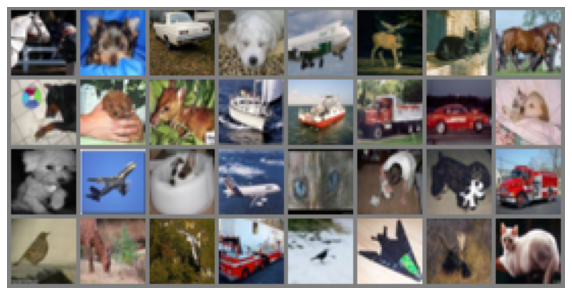

In [ ]:
img, label = next(iter(train_dataloader))
imshow(torchvision.utils.make_grid(img))

## Model

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = self.flatten(x)
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)

    return x

model = ConvNet().to(device)

## Train

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_total_steps = len(train_dataloader)

model.train()
for epoch in range(num_epochs):
  for i, (img, label) in enumerate(train_dataloader):
    img, label = img.to(device), label.to(device)

    y_logits = model(img)
    loss = loss_fn(y_logits, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 300 == 0:
      print(f'Epoch {epoch+1}/{num_epochs} | Step {i+1}/{n_total_steps}, Loss {loss.item():.4f}')

Epoch 1/3 | Step 300/1563, Loss 1.7037
Epoch 1/3 | Step 600/1563, Loss 1.5327
Epoch 1/3 | Step 900/1563, Loss 1.5441
Epoch 1/3 | Step 1200/1563, Loss 1.3956
Epoch 1/3 | Step 1500/1563, Loss 1.2424
Epoch 2/3 | Step 300/1563, Loss 1.3751
Epoch 2/3 | Step 600/1563, Loss 1.1422
Epoch 2/3 | Step 900/1563, Loss 1.2580
Epoch 2/3 | Step 1200/1563, Loss 1.2920
Epoch 2/3 | Step 1500/1563, Loss 1.2753
Epoch 3/3 | Step 300/1563, Loss 1.1405
Epoch 3/3 | Step 600/1563, Loss 1.1448
Epoch 3/3 | Step 900/1563, Loss 0.9982
Epoch 3/3 | Step 1200/1563, Loss 1.2434
Epoch 3/3 | Step 1500/1563, Loss 1.0011


## Eval

In [ ]:
model.eval()
with torch.no_grad():
  n_correct, n_samples = 0, 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]
  for imgs, labels in test_dataloader:
    imgs, labels = imgs.to(device), labels.to(device)
    y_logits = model(imgs)

    preds = torch.argmax(y_logits, dim=1)
    n_samples += labels.size(0)
    n_correct += (preds == labels).sum().item()

    for i in range(len(labels)):
      label = labels[i]
      pred = preds[i]

      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  acc = 100.0 * n_correct / n_samples
  print(f"Accuracy: {acc} %")

  for i in range(10):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f"Accuracy of {class_names[i]} : {acc}%")

Accuracy: 57.59 %
Accuracy of airplane : 66.9%
Accuracy of automobile : 69.7%
Accuracy of bird : 47.9%
Accuracy of cat : 33.9%
Accuracy of deer : 43.9%
Accuracy of dog : 43.1%
Accuracy of frog : 82.8%
Accuracy of horse : 51.4%
Accuracy of ship : 75.6%
Accuracy of truck : 60.7%


**Conclusion** \
With only a few training epoch, we have achieved pretty decent accuracy across all classes 